# Telecom Churn dataset classification using tensorflow and keras

<img src="https://digital.report/wp-content/uploads/2017/04/558519547-1078x516.jpg">

In [1]:
print()
print(format('Recipe for Data Science Competition - DSC_Recipe_13','*^65'))
print(format('Classification with OpenML telco Churn dataset using tensorflow and keras', '*^95'))    
print(format('Package: scikit-learn, Keras and TensorFlow ','*^65'))            
print(format('Model: Keras Model','*^65'))            
print(format('DataSet: OpenML telco Churn Dataset', '*^65'))    
print(format('Model selection: using Grid Search Cross Validation (GSCV)', '*^65'))


*******Recipe for Data Science Competition - DSC_Recipe_13*******
***********Classification with OpenML telco Churn dataset using tensorflow and keras***********
**********Package: scikit-learn, Keras and TensorFlow ***********
***********************Model: Keras Model************************
***************DataSet: OpenML telco Churn Dataset***************
***Model selection: using Grid Search Cross Validation (GSCV)****


## 0. Loading required libraries

In [1]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils.np_utils import to_categorical        
from sklearn.preprocessing import MinMaxScaler        
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from keras.models import model_from_json
from sklearn.preprocessing import LabelEncoder    
start_time = time.time()

## 1. Helper modules for Descriptive Statistics

In [3]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

In [4]:
def get_top_abs_correlations(df, n=5): 
    au_corr = df.corr().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [5]:
def corrank(X):
    import itertools
    df = pd.DataFrame([[(i,j), 
                X.corr().loc[i,j]] for i,j in list(itertools.combinations(X.corr(), 2))],
                columns=['pairs','corr'])
    print(df.sort_values(by='corr',ascending=False))
    print()

In [6]:
# Helper module for Label Encoding for Categorical Features
def dummyEncode(df):
    columnsToEncode = list(df.select_dtypes(include=['category', 'object']))
    le = LabelEncoder()
    for feature in columnsToEncode:
        try:
            df[feature] = le.fit_transform(df[feature])
        except:
            print('Error encoding '+feature)
    return df

## 2. Loading dataset

In [7]:
def load_dataset(filename):
        
    dataset = pd.read_csv(filename, sep = ',')
        
    print(dataset.shape);    print(dataset.head(5));    print(dataset.columns);
    print(dataset.dtypes)
        
    feature_names = ['Account_Length', 'Vmail_Message', 'Day_Mins', 'Eve_Mins', 
    'Night_Mins','Intl_Mins', 'CustServ_Calls', 'Intl_Plan', 'Vmail_Plan',
    'Day_Calls', 'Day_Charge', 'Eve_Calls', 'Eve_Charge', 'Night_Calls',
    'Night_Charge', 'Intl_Calls', 'Intl_Charge', 'State', 'Area_Code']
        
    target = 'Churn'
        
    dataset = dummyEncode(dataset[['Account_Length', 'Vmail_Message', 'Day_Mins', 'Eve_Mins', 
    'Night_Mins','Intl_Mins', 'CustServ_Calls', 'Intl_Plan', 'Vmail_Plan',
    'Day_Calls', 'Day_Charge', 'Eve_Calls', 'Eve_Charge', 'Night_Calls',
    'Night_Charge', 'Intl_Calls', 'Intl_Charge', 'State', 'Area_Code', 'Churn']])
        
    return feature_names, target, dataset

## 3. Find missing values in dataset if exists

In [8]:
    def find_miising_value(feature_names, target, dataset):
        
        print()
        print('#---------------------------------------------------------------')
        print('Check for Mising Value or NaN Value in the Dataset')
        print('#---------------------------------------------------------------')
        # Method - 1
        # Count Number of Missing Value on Each Column    
        print('\nCount Number of Missing Value on Each Column: ')        
        print(dataset.isnull().sum(axis=0))

        # Method - 2
        # Check if there are any missing values in Dataset
        feature_count = dataset.columns[dataset.isnull().sum() != 0].size
        print()
        print("Total Features with missing Values = " + str(feature_count))

        if (feature_count):
            print()
            print("Features with NaN => {}".format(list(dataset.columns[dataset.isnull().sum() != 0])))
            print('Count Number of Missing Value on Each Column: ')        
            print(dataset[dataset.columns[dataset.isnull().sum() != 0]].isnull().sum().sort_values(ascending = False))

        print()
        print('#---------------------------------------------------------------')
        print('Check and Remove constant columns in the Dataset')
        print('#---------------------------------------------------------------')
        colsToRemove = []
        for col in dataset.columns:
            if col not in ['Churn']:
                if dataset[col].std() == 0: 
                    colsToRemove.append(col)
        print()
        print("Removed `{}` Constant Columns: ".format(len(colsToRemove)))
        print(colsToRemove)
        # remove constant columns in the Dataset
        dataset.drop(colsToRemove, axis=1, inplace=True)

        print()
        print('#---------------------------------------------------------------')
        print('Check and Remove Duplicate Columns in the Dataset')
        print('#---------------------------------------------------------------')
        print()
        print(dataset.columns); print(dataset.head(5))
        print('\nDuplicate Columns in the Dataset: \n', dataset.columns.duplicated())        
        dataset = dataset.loc[:, ~dataset.columns.duplicated()]
        print()
        print(dataset.columns); print(dataset.head(5))
        
        print()
        print('#---------------------------------------------------------------')
        print('Check and Drop Sparse Data/Columns in the Dataset')
        print('#---------------------------------------------------------------')
        flist = [x for x in dataset.columns if not x in ['Churn']]
        print(); print(flist)
        for f in flist:
            if len(np.unique(dataset[f])) < 2:
                print('Feature contains Sparse Data: ', f)
                dataset.drop(f, axis=1, inplace=True)
        print()
        print(dataset.columns); print(dataset.head(5))
        
        # --------------------------------------------------
        # Missing Values treatment in the DataSet (if any)
        # --------------------------------------------------    

        # Filling NULL values according to their dataTypes
        # Group Dataset according to different dataTypes
        gd = dataset.columns.to_series().groupby(dataset.dtypes).groups
        print('\nGroup Columns according to their dataTypes: \n', gd)  
        colNames = dataset.columns.values.tolist()
        for colName in colNames:
            if dataset[colName].dtypes == 'int64':
                dataset[colName] = dataset[colName].fillna(0)
            if dataset[colName].dtypes == 'float64':
                dataset[colName] = dataset[colName].fillna(0.0) 
            if dataset[colName].dtypes == 'object':
                dataset[colName] = dataset[colName].fillna('Unknown')    

        ## Count Number of Missing Value on Each Column    
        print('\nCount Number of Missing Value on Each Column: ')        
        print(dataset.isnull().sum(axis=0))

        # Check if there are any missing values in Dataset
        feature_count = dataset.columns[dataset.isnull().sum() != 0].size
        print()
        print("Total Features with missing Values = " + str(feature_count))
        
        return(dataset)

## 4. Descriptive statistics and correlation matrix

In [9]:
def data_descriptiveStats(feature_names, target, dataset):
    # Count Number of Missing Value on Each Column    
    print(); print('Count Number of Missing Value on Each Column: ')        
    print(); print(dataset[feature_names].isnull().sum(axis=0))
    print(); print(dataset[target].isnull().sum(axis=0))    
    
    # Get Information on the feature variables
    print(); print('Get Information on the feature variables: ')            
    print(); print(dataset[feature_names].info())
    print(); print(dataset[feature_names].describe())
    
    # correlation
    pd.set_option('precision', 2)
    print(); print(dataset[feature_names].corr())    
    
    # Ranking of Correlation Coefficients among Variable Pairs
    print(); print("Ranking of Correlation Coefficients:")    
    corrank(dataset[feature_names])

    # Print Highly Correlated Variables
    print(); print("Highly correlated variables (Absolute Correlations):")
    print(); print(get_top_abs_correlations(dataset[feature_names], 8))
    
    # Get Information on the target    
    print(); print(dataset[target].describe())    
    print(); print(dataset.groupby(target).size())    

## 5. Data visualisation and correlation graph

In [10]:
    def data_visualization(feature_names, target, dataset):
        # BOX plots USING box and whisker plots
        i = 1
        print(); print('BOX plot of each numerical features')
        plt.figure(figsize=(11,9))     
        for col in feature_names:
            plt.subplot(5,4,i)
            plt.axis('on')
            plt.tick_params(axis='both', left=True, top=False, right=False, bottom=True, 
                            labelleft=False, labeltop=False, labelright=False, labelbottom=False)
            dataset[col].plot(kind='box', subplots=True, sharex=False, sharey=False)
            i += 1
        plt.show()    
    
        # USING histograms
        j = 1
        print(); print('Histogram of each Numerical Feature')
        plt.figure(figsize=(11,9))     
        for col in feature_names:
            plt.subplot(5,4,j)
            plt.axis('on')
            plt.tick_params(axis='both', left=True, top=False, right=False, bottom=False, 
                            labelleft=False, labeltop=False, labelright=False, labelbottom=False)
            dataset[col].hist()
            j += 1
        plt.show()

        # correlation matrix
        print(); print('Correlation Matrix of All Numerical Features')   
        fig = plt.figure(figsize=(11,9))
        ax = fig.add_subplot(111)
        cax = ax.matshow(dataset[feature_names].corr(), vmin=-1, vmax=1, interpolation='none')
        fig.colorbar(cax)
        ticks = np.arange(0,19,1)
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)
        plt.show()

        # Correlation Plot using seaborn
        print(); print("Correlation plot of Numerical features")
        # Compute the correlation matrix
        corr = dataset[feature_names].corr()
        print(corr)
        # Generate a mask for the upper triangle
        mask = np.zeros_like(corr, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        # Set up the matplotlib figure
        f, ax = plt.subplots(figsize=(11, 9))
        # Generate a custom diverging colormap
        cmap = sns.diverging_palette(220, 10, as_cmap=True)
        # Draw the heatmap with the mask and correct aspect ratio
        sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin= -1.0, center=0, square=True, 
                    linewidths=.5, cbar_kws={"shrink": .5})
        plt.show()    
    
        # Pie chart for Categorical Variables
        print(); print('PIE Chart of for Target: ')
        plt.figure(figsize=(11,9)) 
        i = 1
        for colName in [target]:
            labels = []; sizes = [];
            df = dataset.groupby(colName).size()
            for key in df.keys():
                labels.append(key)
                sizes.append(df[key])
            # Plot PIE Chart with %
            plt.subplot(2,2,i)
            plt.axis('on')
            plt.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
                            labelleft=True, labeltop=True, labelright=False, labelbottom=False)        
            plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140)
            plt.axis('equal')
            i += 1; plt.savefig('Piefig.pdf', format='pdf')
        plt.show()    

## 6. Data split to train and test datasets

In [11]:
    def data_split(feature_names, target, dataset):
        
        # Data Transform - Split train : test datasets
        X_train, X_test, y_train, y_test = train_test_split(dataset.loc[:, feature_names], 
                                dataset.loc[:, target], test_size=0.33)
        
        # normalize the dataset i.e. X_train and X_test
        scaler = MinMaxScaler(feature_range=(0, 1))
        X_train = scaler.fit_transform(X_train)    
        X_test = scaler.fit_transform(X_test)    
    
        print(y_train)
        # One-hot encode target vector to create a target matrix
        y_train = to_categorical(y_train)
        y_test = to_categorical(y_test)
        
        print(y_train)
        
        return X_train, X_test, y_train, y_test

In [12]:
    def training_model(X_train, y_train):
        
        model = Sequential()
        model.add(Dense(units = 256, input_dim=19, activation='relu'))
        model.add(Dropout(0.15))
        model.add(Dense(units = 128, activation='relu'))
        model.add(Dropout(0.15))
        model.add(Dense(units = 56, activation='relu'))
        model.add(Dropout(0.15))  
        model.add(Dense(units = 28, activation='relu'))
        model.add(Dropout(0.15))        
        model.add(Dense(units = 2,  activation='softmax'))
        
        # Model Summary
        print(model.summary())                
        
        # Compile the Model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
        
        # Train the Model
        history = model.fit(X_train, y_train, epochs=500, batch_size=64, verbose = 1,
                            validation_split=0.20)        
        
        return(model, history)

In [13]:
    def evaluate_model(model, history, X_test, y_test):
        
        scores = model.evaluate(X_test, y_test)
        print(); print(model.metrics_names); print(scores)
        print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        print(model.summary())        
        
        # list all data in history
        print(history.history.keys()); #print(history.history)
        # summarize history for accuracy
        plt.plot(history.history['acc']); plt.plot(history.history['val_acc']);
        plt.title('model accuracy'); plt.ylabel('accuracy'); plt.xlabel('epoch'); 
        plt.legend(['train', 'test'], loc='upper left'); plt.show()
        # summarize history for loss
        plt.plot(history.history['loss']); plt.plot(history.history['val_loss']);
        plt.title('model loss'); plt.ylabel('loss'); plt.xlabel('epoch');
        plt.legend(['train', 'test'], loc='upper left'); plt.show()        
        
        y_test = np.argmax(y_test, axis = 1)

        print(y_test)

        # Evaluate the skill of the Trained model
        pred_Class          = model.predict_classes(X_test)
        
        print(pred_Class)
        
        acc                 = accuracy_score(y_test, pred_Class)
        classReport         = classification_report(y_test, pred_Class)
        confMatrix          = confusion_matrix(y_test, pred_Class) 
        kappa_score         = cohen_kappa_score(y_test, pred_Class)         
        
        print(); print('Evaluation of the trained model: ')
        print(); print('Accuracy : ', acc)
        print(); print('Kappa Score : ', kappa_score)
        print(); print('Confusion Matrix :\n', confMatrix)
        print(); print('Classification Report :\n',classReport)

        # Confusion matrix
        skplt.metrics.plot_confusion_matrix(y_test,pred_Class,figsize=(9,9)); plt.show()        

        return model

## 7. Make Prediction

In [14]:
    def save_model(model):
        # save model - json
        model_json = model.to_json()
        open('DSC_Recipe_13_model.json', 'w').write(model_json)
        model.save_weights('DSC_Recipe_13_model.h5', overwrite=True)

In [15]:
    def final_prediction(feature_names, filename):
        # load model
        model_architecture = 'DSC_Recipe_13_model.json'
        model_weights = 'DSC_Recipe_13_model.h5'
        model = model_from_json(open(model_architecture).read())
        model.load_weights(model_weights)
        model.summary()
        
        # load dataset
        dataset = pd.read_csv(filename, sep = ',')

        print(dataset.shape);    print(dataset.head(5));    print(dataset.columns);
        print(dataset.dtypes)

        dataset = dummyEncode(dataset)
        
        # normalize the dataset 
        scaler = MinMaxScaler(feature_range=(0, 1))
        # final prediction and results
        predicted_class     = model.predict_classes(scaler.fit_transform(dataset[feature_names]))
        pred_proba          = model.predict(scaler.fit_transform(dataset[feature_names]))
        dataset['predicted_class'] = predicted_class

        # Evaluate the skill of the Trained model
        acc                 = accuracy_score(dataset['Churn'], predicted_class)
        classReport         = classification_report(dataset['Churn'], predicted_class)
        confMatrix          = confusion_matrix(dataset['Churn'], predicted_class) 
        kappa_score         = cohen_kappa_score(dataset['Churn'], predicted_class)         
        
        print(); print('Testing Results of the trained model: ')
        print(); print('Accuracy : ', acc)
        print(); print('Kappa Score : ', kappa_score)
        print(); print('Confusion Matrix :\n', confMatrix)
        print(); print('Classification Report :\n',classReport)
        
        # ROC curves
        skplt.metrics.plot_roc(dataset['Churn'],pred_proba,figsize=(7,7)); plt.show()

        # Confusion matrix
        skplt.metrics.plot_confusion_matrix(dataset['Churn'],
                                            predicted_class,figsize=(7,7)); plt.show()        

        # precision recall curve
        skplt.metrics.plot_precision_recall(dataset['Churn'], pred_proba, 
                title='Precision-Recall Curve', plot_micro=True, 
                classes_to_plot=None, ax=None, figsize=(7,7), 
                cmap='nipy_spectral', title_fontsize='large', 
                text_fontsize='medium'); plt.show()               
        
        dataset.to_csv('FinalResult.csv', index = False, 
                       columns = ['Churn', 'predicted_class'])

## 8. Execute algorithm using functions above


Execution Time 1599326602.0325272 seconds: 
(3333, 21)
   Account_Length  Vmail_Message  Day_Mins  Eve_Mins  Night_Mins  Intl_Mins  \
0             128             25     265.1     197.4       244.7       10.0   
1             107             26     161.6     195.5       254.4       13.7   
2             137              0     243.4     121.2       162.6       12.2   
3              84              0     299.4      61.9       196.9        6.6   
4              75              0     166.7     148.3       186.9       10.1   

   CustServ_Calls Churn Intl_Plan Vmail_Plan  ...  Day_Charge  Eve_Calls  \
0               1    no        no        yes  ...       45.07         99   
1               1    no        no        yes  ...       27.47        103   
2               0    no        no         no  ...       41.38        110   
3               2    no       yes         no  ...       50.90         88   
4               3    no       yes         no  ...       28.34        122   

   Eve_Charg

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


                           pairs  corr
42        (Day_Mins, Day_Charge)  1.00
59        (Eve_Mins, Eve_Charge)  1.00
75    (Night_Mins, Night_Charge)  1.00
90      (Intl_Mins, Intl_Charge)  1.00
24   (Vmail_Message, Vmail_Plan)  0.96
..                           ...   ...
103      (CustServ_Calls, State) -0.03
33        (Vmail_Message, State) -0.03
68       (Night_Mins, Intl_Plan) -0.03
111    (Intl_Plan, Night_Charge) -0.03
124          (Vmail_Plan, State) -0.03

[171 rows x 2 columns]


Highly correlated variables (Absolute Correlations):

Day_Mins       Day_Charge      1.00
Eve_Mins       Eve_Charge      1.00
Night_Mins     Night_Charge    1.00
Intl_Mins      Intl_Charge     1.00
Vmail_Message  Vmail_Plan      0.96
Intl_Plan      Day_Charge      0.05
Day_Mins       Intl_Plan       0.05
Intl_Plan      Area_Code       0.05
dtype: float64

count    3333.00
mean        0.14
std         0.35
min         0.00
25%         0.00
50%         0.00
75%         0.00
max         1.00
Name: Churn,

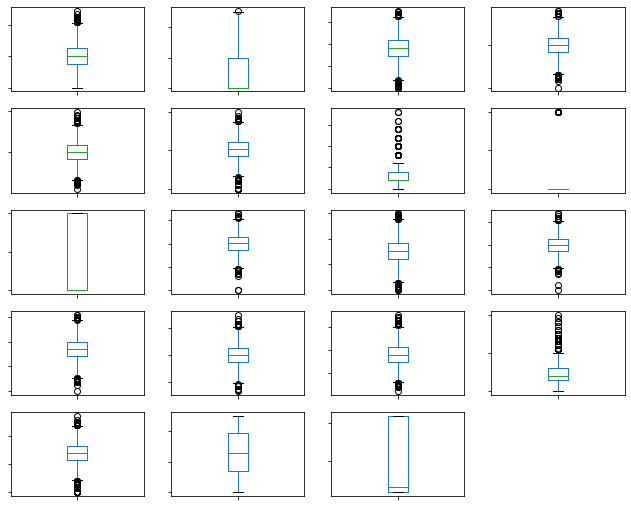


Histogram of each Numerical Feature


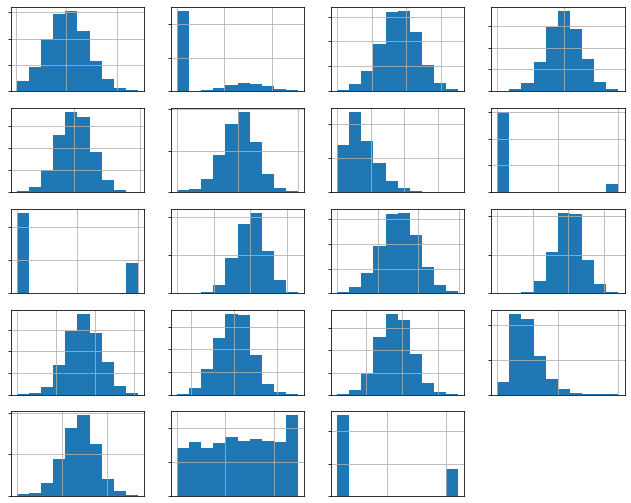


Correlation Matrix of All Numerical Features


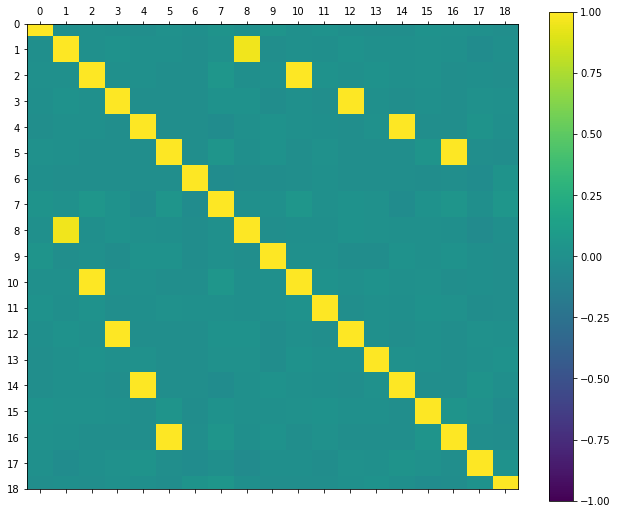


Correlation plot of Numerical features
                Account_Length  Vmail_Message  Day_Mins  Eve_Mins  Night_Mins  \
Account_Length        1.00e+00      -4.63e-03  6.22e-03 -6.76e-03   -8.96e-03   
Vmail_Message        -4.63e-03       1.00e+00  7.78e-04  1.76e-02    7.68e-03   
Day_Mins              6.22e-03       7.78e-04  1.00e+00  7.04e-03    4.32e-03   
Eve_Mins             -6.76e-03       1.76e-02  7.04e-03  1.00e+00   -1.26e-02   
Night_Mins           -8.96e-03       7.68e-03  4.32e-03 -1.26e-02    1.00e+00   
Intl_Mins             9.51e-03       2.86e-03 -1.02e-02 -1.10e-02   -1.52e-02   
CustServ_Calls       -3.80e-03      -1.33e-02 -1.34e-02 -1.30e-02   -9.29e-03   
Intl_Plan             2.47e-02       8.75e-03  4.94e-02  1.91e-02   -2.89e-02   
Vmail_Plan            2.92e-03       9.57e-01 -1.68e-03  2.15e-02    6.08e-03   
Day_Calls             3.85e-02      -9.55e-03  6.75e-03 -2.15e-02    2.29e-02   
Day_Charge            6.21e-03       7.76e-04  1.00e+00  7.05e-03    

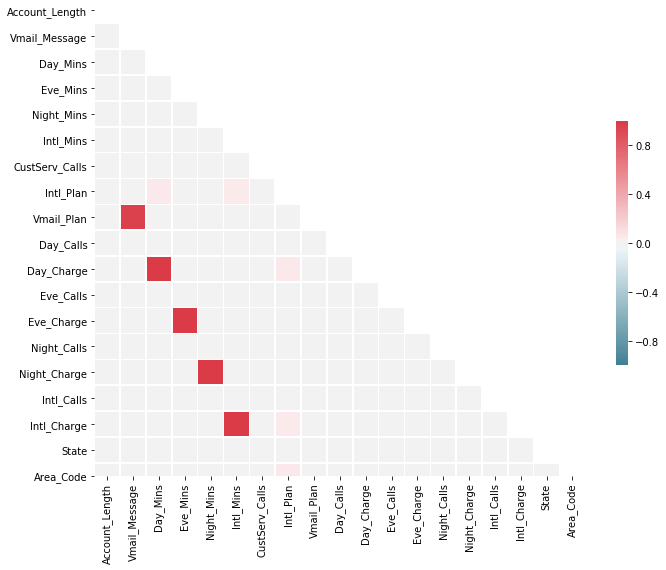


PIE Chart of for Target: 


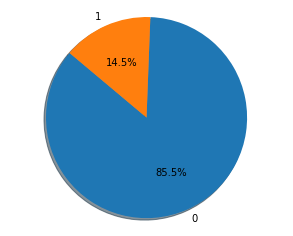

712     0
2297    0
2446    0
1781    0
326     0
       ..
221     0
599     0
2491    0
372     1
1326    0
Name: Churn, Length: 2233, dtype: int64
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               5120      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 56)                7224      
____________________________________________

Epoch 50/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1610 - acc: 0.9404 - val_loss: 0.3176 - val_acc: 0.9195
Epoch 51/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1279 - acc: 0.9522 - val_loss: 0.3178 - val_acc: 0.9105
Epoch 52/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1508 - acc: 0.9464 - val_loss: 0.3311 - val_acc: 0.9128
Epoch 53/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1170 - acc: 0.9594 - val_loss: 0.2625 - val_acc: 0.9217
Epoch 54/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1166 - acc: 0.9605 - val_loss: 0.2579 - val_acc: 0.9172
Epoch 55/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1246 - acc: 0.9549 - val_loss: 0.3204 - val_acc: 0.9150
Epoch 56/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1077 - acc: 0.9594 - val_loss: 0.2860 - val_acc: 0.9128
Epoch 57/500
28/28 [==============================] - 0s 2ms/step - loss: 0.

Epoch 112/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0781 - acc: 0.9705 - val_loss: 0.4274 - val_acc: 0.9217
Epoch 113/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0637 - acc: 0.9795 - val_loss: 0.4375 - val_acc: 0.9172
Epoch 114/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0497 - acc: 0.9799 - val_loss: 0.4178 - val_acc: 0.9105
Epoch 115/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0462 - acc: 0.9848 - val_loss: 0.4781 - val_acc: 0.9172
Epoch 116/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0425 - acc: 0.9874 - val_loss: 0.4802 - val_acc: 0.9195
Epoch 117/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0578 - acc: 0.9825 - val_loss: 0.4921 - val_acc: 0.9083
Epoch 118/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0351 - acc: 0.9911 - val_loss: 0.4755 - val_acc: 0.9038
Epoch 119/500
28/28 [==============================] - 0s 2ms/step - 

Epoch 235/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0195 - acc: 0.9967 - val_loss: 0.5896 - val_acc: 0.9105
Epoch 236/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0271 - acc: 0.9869 - val_loss: 0.5985 - val_acc: 0.9195
Epoch 237/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0171 - acc: 0.9932 - val_loss: 0.6819 - val_acc: 0.9105
Epoch 238/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0260 - acc: 0.9912 - val_loss: 0.5754 - val_acc: 0.9128
Epoch 239/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0274 - acc: 0.9903 - val_loss: 0.6057 - val_acc: 0.9016
Epoch 240/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0269 - acc: 0.9940 - val_loss: 0.6756 - val_acc: 0.9150
Epoch 241/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0175 - acc: 0.9944 - val_loss: 0.6784 - val_acc: 0.8971
Epoch 242/500
28/28 [==============================] - 0s 2ms/step - 

Epoch 358/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0365 - acc: 0.9861 - val_loss: 0.4614 - val_acc: 0.8971
Epoch 359/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0303 - acc: 0.9901 - val_loss: 0.4972 - val_acc: 0.9038
Epoch 360/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0317 - acc: 0.9865 - val_loss: 0.6169 - val_acc: 0.9083
Epoch 361/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0331 - acc: 0.9905 - val_loss: 0.6150 - val_acc: 0.9172
Epoch 362/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0232 - acc: 0.9889 - val_loss: 0.5866 - val_acc: 0.9060
Epoch 363/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0236 - acc: 0.9921 - val_loss: 0.5787 - val_acc: 0.9016
Epoch 364/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0145 - acc: 0.9932 - val_loss: 0.6252 - val_acc: 0.9060
Epoch 365/500
28/28 [==============================] - 0s 3ms/step - 

Epoch 481/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0411 - acc: 0.9839 - val_loss: 0.5960 - val_acc: 0.9172
Epoch 482/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0184 - acc: 0.9921 - val_loss: 0.6371 - val_acc: 0.9150
Epoch 483/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0204 - acc: 0.9936 - val_loss: 0.7035 - val_acc: 0.9083
Epoch 484/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0113 - acc: 0.9958 - val_loss: 0.7892 - val_acc: 0.9105
Epoch 485/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0143 - acc: 0.9965 - val_loss: 0.6961 - val_acc: 0.8993
Epoch 486/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0188 - acc: 0.9931 - val_loss: 0.7267 - val_acc: 0.9060
Epoch 487/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0108 - acc: 0.9966 - val_loss: 0.6858 - val_acc: 0.9016
Epoch 488/500
28/28 [==============================] - 0s 2ms/step - 

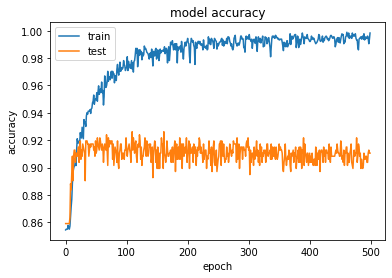

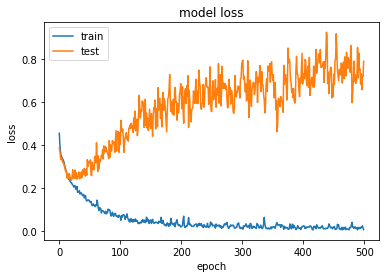

[0 1 0 ... 0 0 0]
[0 1 0 ... 0 0 0]

Evaluation of the trained model: 

Accuracy :  0.8909090909090909

Kappa Score :  0.5422293430991073

Confusion Matrix :
 [[888  51]
 [ 69  92]]

Classification Report :
               precision    recall  f1-score   support

           0       0.93      0.95      0.94       939
           1       0.64      0.57      0.61       161

    accuracy                           0.89      1100
   macro avg       0.79      0.76      0.77      1100
weighted avg       0.89      0.89      0.89      1100



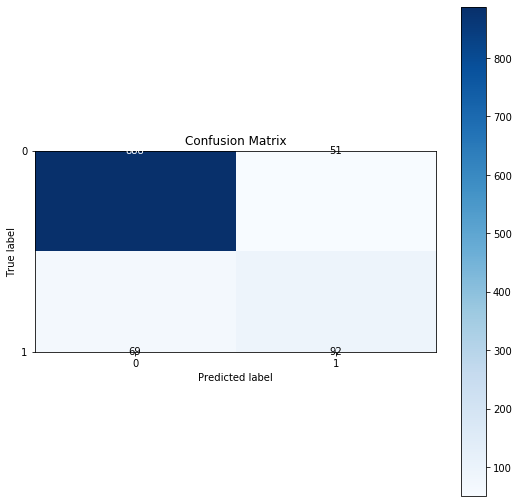

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               5120      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 56)                7224      
_________________________________________________________________
dropout_2 (Dropout)          (None, 56)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 28)                1

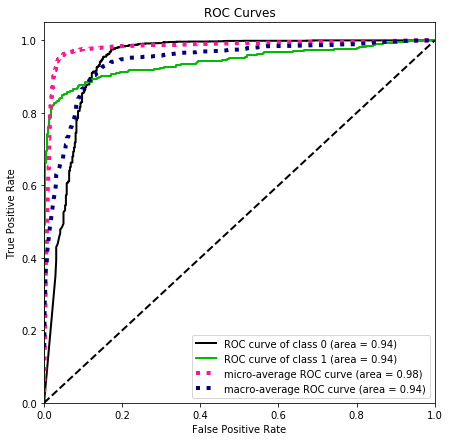

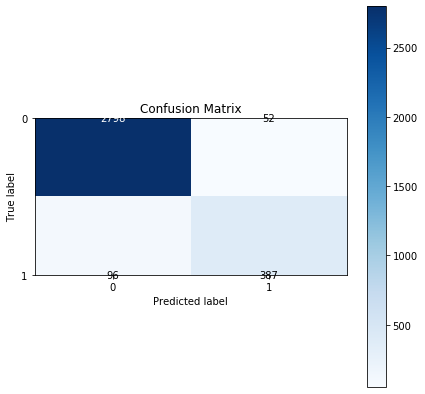

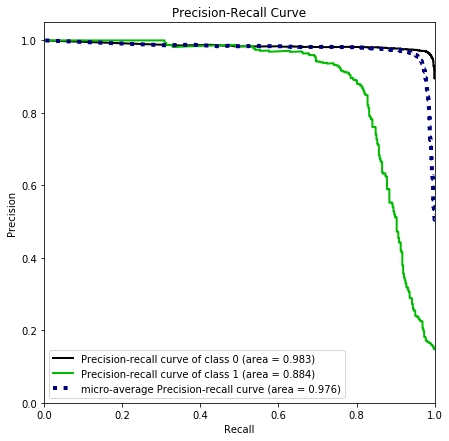


Execution Time 1027.6238837242126 seconds: 


In [16]:
    if __name__ == '__main__':
        print()
        print("Execution Time %s seconds: " % (start_time))
        filename = 'TelcoCustomerChurnDataset.csv'
        
        feature_names, target, dataset = load_dataset(filename)
        dataset = find_miising_value(feature_names, target, dataset)
        data_descriptiveStats(feature_names, target, dataset)
        data_visualization(feature_names, target, dataset)
        X_train, X_test, y_train, y_test = data_split(feature_names, target, dataset)
        model, history  = training_model(X_train, y_train)
        model= evaluate_model(model, history, X_test, y_test)
        save_model(model) 

        test_filename = 'TelcoCustomerChurnDataset.csv'
        final_prediction(feature_names, test_filename)

        print()
        print("Execution Time %s seconds: " % (time.time() - start_time))

## References 

<ol>
    <li><a href="https://www.tensorflow.org/">Tensorflow</a></li>
</ol>